# **The problem of the $n$ queens**

***n_queens.ipynb***

The $n$ queens problem: place $n$ queens on an $n \times n$ chessboard so that none of them can be captured by another queen in one move.

&copy; Copyright 2025-2026 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the necessary packages
%pip install -q xpress matplotlib

## Problem description and formulation

In the game of chess, the queen can move in a straight line horizontally, vertically, or diagonally any number of fields. The problem consists of finding the placement of as many queens as possible on an $n\times n$ chessboard so that no queen can capture another in a single move.

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/2/2c/Eight_Queens12_positions.gif" alt="Image (from Wikipedia)"/>
</p>

This problem can be cast as an optimization problem where we try to maximize the number of queens placed on an $n\times n$ chessboard. An upper bound is clearly $n$ as there cannot be more queens than rows (or columns). The problem has one yes/no decision variable for each cell, so we need $n^2$ **binary** variables, hereby denoted by $place_{ij}, \forall i,j \in \mathcal{N}$. Note that $n$ is just a parameter and it can be set arbitrarily high, and $\mathcal{N} = \{1,..,n\}$.

$$
\max \sum_{i,j \in \mathcal{N}} place_{i,j}$$

Subject to:

* At most one queen in each row:
$$\sum_{j \in \mathcal{N}} place_{i,j} \leq 1, \qquad \forall i \in \mathcal{N}$$

* At most one queen in each column:
$$\sum_{i \in \mathcal{N}} place_{i,j} \leq 1, \qquad \forall j \in \mathcal{N}$$

* At most one queen on every diagonal (north-east and north-west):
$$\sum_{j = \max(0,k-n+1)}^{\min(0,k+1, n)} place_{(k-j),j} \leq 1, \qquad \forall k \in \{1,..,2n-2\} \\
\sum_{j = \max(0,-k)}^{\min(0,n-k, n)} place_{(k+j),j} \leq 1, \qquad \forall k \in \{2-n,..,n-1\}$$

## Model implementation and results

The code cell below demonstrates the implementation of the above model formulation and prints the results using the Xpress Python interface.

After importing the necessary modules, a 2D Numpy array of binary decision variables is created by specifying the value 'binary' for the **vartype** argument. When passing integer values for the first two arguments to [prob.addVariables()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html), the result is a NumPy array of variables.

The objective and three sets of constraints are then created and directly added to the problem directly by passing the corresponding expression as a list comprehension. The problem is then optimized and an optimal solution is printed.

In [ ]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt

prob = xp.problem()

# Variables: one per cell.
n = 8
N = range(n)
place = prob.addVariables(n,n,vartype=xp.binary, name='place') # Create a 2D numpy array of (i,j) variables and link them to problem p

# Objective function: number of queens
prob.setObjective(xp.Sum(place), sense=xp.maximize)

# Constraints 1: at most one queen in each row
prob.addConstraint(xp.Sum(place[i,j] for j in N) <= 1 for i in N)

# Constraints 2: at most one queen in each column
prob.addConstraint(xp.Sum(place[i,j] for i in N) <= 1 for j in N)

# Constraints 3: at most one queen on every diagonal (north-east and north-west) 
diagonal1 = [xp.Sum(place[k-j, j] for j in range(max(0, k-n+1), min(k+1, n))) <= 1
             for k in range(1, 2*n-2)]
diagonal2 = [xp.Sum(place[k+j, j] for j in range(max(0, -k), min(n-k, n))) <= 1
             for k in range(2-n, n-1)]
prob.addConstraint(diagonal1, diagonal2)

prob.optimize()

print(f'Here is a solution with {prob.attributes.objval} queens:')
xsol = prob.getSolution(place)
for i in N:
    for j in N:
        if xsol[i,j] > 0.5:
            print(f'\nQueen placed in row {i+1}, column {j+1}.', end=' ')

Now we use the *matplotlib* package to visualize the solution in an $n\times n$ grid.

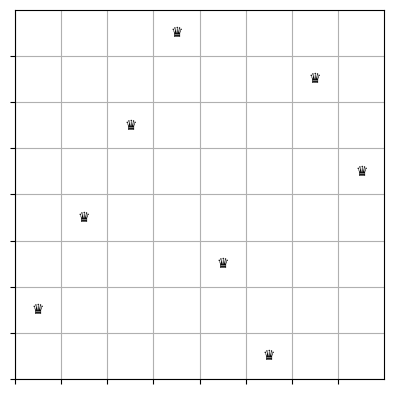

In [2]:
# Visualize solution
fig, ax = plt.subplots()

min_val, max_val, diff = 0, n, 1

N_points = (max_val - min_val) / diff
ind_array = np.arange(min_val, max_val, diff)

for i in N:
    for j in N:
        c = '\u265B' if (xsol[i][j] > 0.5) else ' ' 
        ax.text (i, j, c, va='center', ha='center')

ax.set_aspect('equal', 'box')
#set tick marks for grid
ax.set_xticks(np.arange(min_val-diff/2, max_val-diff/2))
ax.set_yticks(np.arange(min_val-diff/2, max_val-diff/2))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(min_val-diff/2, max_val-diff/2)
ax.set_ylim(min_val-diff/2, max_val-diff/2)
ax.grid()
plt.show()